# Neural Network Autoencoder

## Setup and Data Load

### Import + config

In [23]:
import pandas as pd
import numpy as np

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

# Seed
SEED = 42
np.random.seed(SEED)

# Figure directory
FIG_DIR = Path("../experiments/figures/neural")
FIG_DIR.mkdir(parents=True, exist_ok=True)

def savefig(name):
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches="tight")
    print(f"[saved] {FIG_DIR}")

print("Neural block initialized. Figures will save to:", FIG_DIR)

Neural block initialized. Figures will save to: ..\experiments\figures\neural


###  Load processed train.csv & test.csv

In [12]:

train = pd.read_csv("../data/processed/train.csv")
test  = pd.read_csv("../data/processed/test.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Extract target
y = train["Class"].astype("int32")

# Drop unwanted columns
drop_cols = ["Class", "timestamp"]

# Drop possible ID columns if present
id_cols = ["merchant_id", "account_id", "device_type","geo_bucket"]
for col in id_cols:
    if col in train.columns:
        drop_cols.append(col)

X_train = train.drop(columns=drop_cols, errors="ignore")
X_test  = test.drop(columns=drop_cols, errors="ignore")

# Ensure only numeric columns
num_cols = X_train.select_dtypes(include=["number"]).columns
X_train = X_train[num_cols]
X_test  = X_test[num_cols]

# Combine for global scaling
X_all = pd.concat([X_train, X_test], ignore_index=True)

print("Final feature count:", X_all.shape[1])
print("Numeric-only columns confirmed.")

Train shape: (227845, 61)
Test shape: (56962, 61)
Final feature count: 55
Numeric-only columns confirmed.


### Scale inputs for neural nets

In [13]:
scaler_nn = StandardScaler()

# Fit on combined dataset (global scaling)
X_all_scaled = scaler_nn.fit_transform(X_all)

# Transform train and test
X_train_scaled = scaler_nn.transform(X_train)
X_test_scaled  = scaler_nn.transform(X_test)

print("Scaled train shape:", X_train_scaled.shape)
print("Scaled test shape:", X_test_scaled.shape)
print("Scaler mean (first 5):", scaler_nn.mean_[:5])
print("Scaler var (first 5):", scaler_nn.var_[:5])

Scaled train shape: (227845, 55)
Scaled test shape: (56962, 55)
Scaler mean (first 5): [ 9.48138596e+04  1.17715676e-15  3.37699090e-16 -1.39899632e-15
  2.09465245e-15]
Scaler var (first 5): [2.25511609e+09 3.83647578e+00 2.72681045e+00 2.29902117e+00
 2.00467678e+00]


## MLPClassifier 

### Define & train MLPClassifier

In [15]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(
    X_train_scaled, y, test_size=0.2, random_state=SEED, stratify=y
)


from collections import Counter

counter = Counter(y_train_nn)
fraud_weight = counter[0] / counter[1]     # weight for fraud class
sample_weight = np.where(y_train_nn == 1, fraud_weight, 1.0)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    max_iter=100,
    random_state=SEED,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    learning_rate_init=0.001
)

print("Training MLPClassifier...")
mlp.fit(X_train_nn, y_train_nn, sample_weight=sample_weight)

print("Training complete.")
print("Best loss:", mlp.best_loss_)
print("Iterations:", mlp.n_iter_)

Training MLPClassifier...
Training complete.
Best loss: None
Iterations: 14


### Predict probabilities

In [16]:
train["mlp_proba"] = mlp.predict_proba(X_train_scaled)[:, 1]
test["mlp_proba"]  = mlp.predict_proba(X_test_scaled)[:, 1]

print("MLP probabilities added to train and test.")
print(train["mlp_proba"].describe())

MLP probabilities added to train and test.
count    2.278450e+05
mean     1.769160e-02
std      7.336884e-02
min      6.823927e-57
25%      2.908097e-04
50%      1.361895e-03
75%      6.428523e-03
max      1.000000e+00
Name: mlp_proba, dtype: float64


### MLP Vs previous models

In [17]:
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix


mlp_train_proba = mlp.predict_proba(X_train_scaled)[:, 1]

mlp_pr_auc = average_precision_score(y, mlp_train_proba)
mlp_roc_auc = roc_auc_score(y, mlp_train_proba)

mlp_preds_05 = (mlp_train_proba >= 0.5).astype(int)
cm_05 = confusion_matrix(y, mlp_preds_05)

print("MLP PR-AUC:", mlp_pr_auc)
print("MLP ROC-AUC:", mlp_roc_auc)
print("Confusion matrix @0.5 threshold:\n", cm_05)

comp_path = "../experiments/metrics/model_comparison.csv"
prev_comp = pd.read_csv(comp_path)

mlp_row = pd.DataFrame([{
    "model": "mlp",
    "pr_auc": mlp_pr_auc,
    "roc_auc": mlp_roc_auc
}])

comparison = pd.concat([prev_comp, mlp_row], ignore_index=True)

print("\nUpdated comparison table:")
print(comparison)


MLP PR-AUC: 0.780308233838796
MLP ROC-AUC: 0.9904324347474227
Confusion matrix @0.5 threshold:
 [[226459    992]
 [    25    369]]

Updated comparison table:
                 model  precision    recall        f1    pr_auc  cost_test  \
0           LogReg_0.5   0.059147  0.877551  0.110825  0.726001   128400.0   
1     RandomForest_0.5   0.960526  0.744898  0.839080  0.825907   125150.0   
2          XGBoost_0.5   0.951807  0.806122  0.872928  0.849873    95200.0   
3  XGBoost_best_thresh   0.688525  0.857143  0.763636  0.849873    71900.0   
4                  mlp        NaN       NaN       NaN  0.780308        NaN   
5                  mlp        NaN       NaN       NaN  0.780308        NaN   
6                  mlp        NaN       NaN       NaN  0.780308        NaN   

    roc_auc  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4  0.990432  
5  0.990432  
6  0.990432  


In [18]:
comparison.to_csv("../experiments/metrics/model_comparison.csv", index=False)


### save model

In [19]:
from joblib import dump

model_path = "../experiments/models/mlp.joblib"
dump(mlp, model_path)

print("MLP model saved to:", model_path)

MLP model saved to: ../experiments/models/mlp.joblib


### Visualize MLP latent representation

In [20]:

y_all = np.concatenate([train["Class"].values, test["Class"].values])


W1 = mlp.coefs_[0]        # (input_dim, 128)
b1 = mlp.intercepts_[0]   # (128,)


H = np.maximum(0, X_all_scaled @ W1 + b1)   

print("Hidden activation shape:", H.shape)




Hidden activation shape: (284807, 128)


[saved] ..\experiments\figures\neural


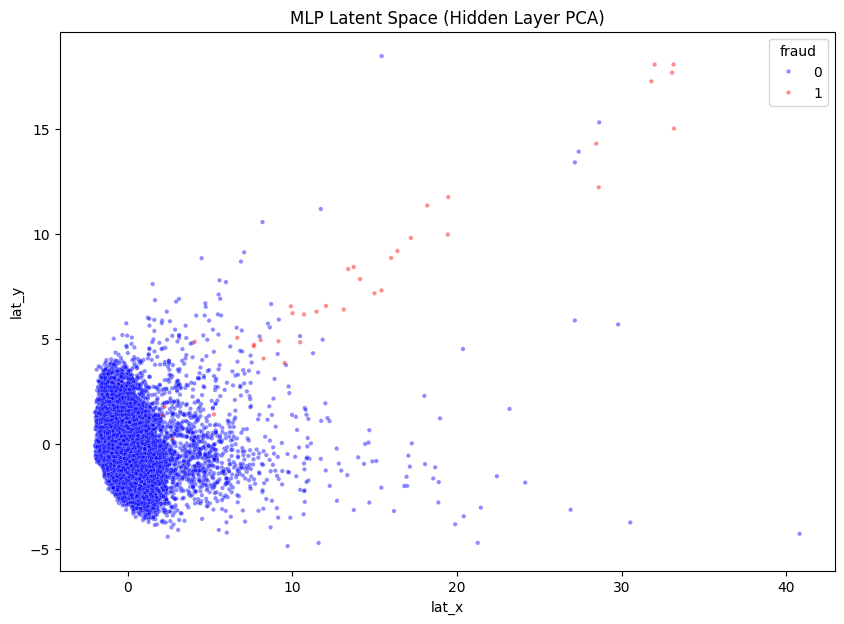

In [24]:
pca_latent = PCA(n_components=2, random_state=SEED)
latent_2d = pca_latent.fit_transform(H)

df_latent = pd.DataFrame({
    "lat_x": latent_2d[:, 0],
    "lat_y": latent_2d[:, 1],
    "fraud": y_all
})

# 5. Plot and save 
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_latent.sample(20000),
    x="lat_x", y="lat_y",
    hue="fraud",
    palette={0: "blue", 1: "red"},
    alpha=0.45,
    s=10
)
plt.title("MLP Latent Space (Hidden Layer PCA)")
savefig("mlp_latent_pca.png")
plt.show()


## PyTorch Autoencoder (more impressive + generates latent features)

strucutre:
    
    Input → Encoder → Latent Code → Decoder → Reconstructed Input
goal:
    
    PyTorch Autoencoder (more impressive + generates latent features)

In [25]:
X_all.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'hour', 'dayofweek', 'amount_log', 'amount_scaled', 'account_age_days',
       'merchant_freq', 'account_txn_count', 'device_freq',
       'last_5_mean_amount', 'last_5_count', 'merchant_id_fe',
       'device_type_fe', 'geo_bucket_fe', 'account_id_fe', 'amount_times_age',
       'is_new_merchant', 'merchant_id_missing', 'device_type_missing',
       'geo_bucket_missing', 'account_age_days_missing', 'pca_x', 'pca_y',
       'anomaly_score', 'is_anomaly', 'cluster_id'],
      dtype='object')

### Define Autoencoder architecture

In [26]:


input_dim = X_train_scaled.shape[1]   # no of features, ~55

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8)   # latent dim
        )

        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)   # reconstruct original vector
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed

    def encode(self, x):
        return self.encoder(x)


# Initialize model
autoencoder = Autoencoder(input_dim)

print(autoencoder)


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=55, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=55, bias=True)
  )
)


### Train Autoencoder

In [27]:
# Convert numpy arrays → tensors
X_tensor = torch.tensor(X_all_scaled, dtype=torch.float32)

# Dataset + Loader
batch_size = 128
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Loss + Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

EPOCHS = 20
losses = []

print("Training autoencoder...")

for epoch in range(EPOCHS):
    total_loss = 0.0
    
    for batch in loader:
        x = batch[0]   # batch input

        # Forward pass
        reconstructed = autoencoder(x)

        # Compute loss (reconstruction error)
        loss = criterion(reconstructed, x)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(loader)
    losses.append(epoch_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}  Loss: {epoch_loss:.6f}")

print("Training complete.")

Training autoencoder...
Epoch 1/20  Loss: 0.447021
Epoch 2/20  Loss: 0.299203
Epoch 3/20  Loss: 0.254380
Epoch 4/20  Loss: 0.224615
Epoch 5/20  Loss: 0.207296
Epoch 6/20  Loss: 0.185564
Epoch 7/20  Loss: 0.174880
Epoch 8/20  Loss: 0.167031
Epoch 9/20  Loss: 0.161010
Epoch 10/20  Loss: 0.157900
Epoch 11/20  Loss: 0.153893
Epoch 12/20  Loss: 0.150103
Epoch 13/20  Loss: 0.146543
Epoch 14/20  Loss: 0.141665
Epoch 15/20  Loss: 0.136473
Epoch 16/20  Loss: 0.133484
Epoch 17/20  Loss: 0.130998
Epoch 18/20  Loss: 0.131985
Epoch 19/20  Loss: 0.127382
Epoch 20/20  Loss: 0.127739
Training complete.


[saved] ..\experiments\figures\neural


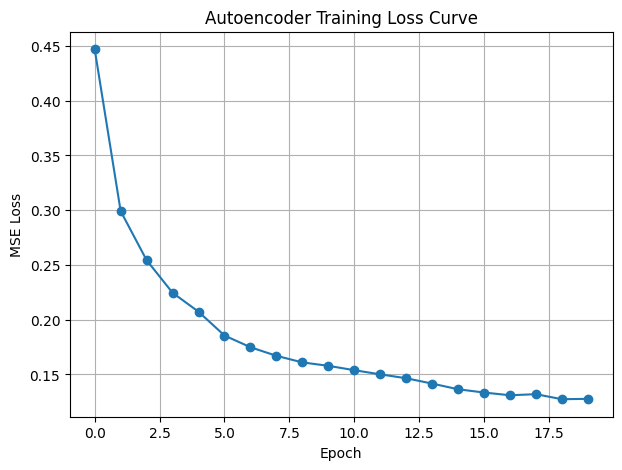

In [28]:
plt.figure(figsize=(7,5))
plt.plot(losses, marker='o')
plt.title("Autoencoder Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)

savefig("ae_training_loss.png")
plt.show()


### Autoencoder Training Summary

In this section, we trained an unsupervised autoencoder on all scaled transaction features to learn normal behavioral patterns.

The autoencoder compresses each transaction into an 8-dimensional latent representation and then reconstructs the original input. Training minimizes reconstruction error (MSE) without using fraud labels.

The smooth decrease in training loss indicates the model successfully learned the structure of normal transactions. Transactions that deviate from these learned patterns will produce higher reconstruction errors, making this a strong anomaly signal.

The learned latent vectors and reconstruction error will later be used as additional features in the stacking model, providing behavior-based intelligence that complements supervised fraud models.


### Compute latent representations

In [29]:
autoencoder.eval()  # inference mode

with torch.no_grad():
    # Encode all data
    latent_all = autoencoder.encode(
        torch.tensor(X_all_scaled, dtype=torch.float32)
    ).numpy()

print("Latent shape:", latent_all.shape)  # (n_samples, 8)

# Split back into train and test
n_train = len(train)

latent_train = latent_all[:n_train]
latent_test  = latent_all[n_train:]

# Add latent columns
latent_cols = [f"ae_latent_{i+1}" for i in range(latent_train.shape[1])]

for i, col in enumerate(latent_cols):
    train[col] = latent_train[:, i]
    test[col]  = latent_test[:, i]

print("Latent features added.")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Latent shape: (284807, 8)
Latent features added.
Train shape: (227845, 70)
Test shape: (56962, 70)


### Compute reconstruction error


In [30]:

autoencoder.eval()

with torch.no_grad():
    # Reconstruct train data
    X_train_recon = autoencoder(
        torch.tensor(X_train_scaled, dtype=torch.float32)
    ).numpy()

    # Reconstruct test data
    X_test_recon = autoencoder(
        torch.tensor(X_test_scaled, dtype=torch.float32)
    ).numpy()

# Compute reconstruction error (MSE per sample)
recon_error_train = np.mean((X_train_scaled - X_train_recon) ** 2, axis=1)
recon_error_test  = np.mean((X_test_scaled - X_test_recon) ** 2, axis=1)

# Add to dataframes
train["ae_recon_error"] = recon_error_train
test["ae_recon_error"]  = recon_error_test

print("Reconstruction error added.")
print("Train recon error stats:")
print(train["ae_recon_error"].describe())

print("\nTest recon error stats:")
print(test["ae_recon_error"].describe())

Reconstruction error added.
Train recon error stats:
count    227845.000000
mean          0.125886
std           0.175154
min           0.004932
25%           0.043165
50%           0.077176
75%           0.142487
max          25.822874
Name: ae_recon_error, dtype: float64

Test recon error stats:
count    56962.000000
mean         0.126976
std          0.173002
min          0.005876
25%          0.042886
50%          0.077740
75%          0.143909
max          8.209039
Name: ae_recon_error, dtype: float64


### Autoencoder Reconstruction Error

After training the autoencoder, we computed per-transaction reconstruction error using mean squared error between the original input and its reconstruction.

The reconstruction error distribution is right-skewed, with most transactions showing low error and a small fraction exhibiting very high error. This indicates that the model learned normal transaction behavior well and fails to reconstruct rare or unusual patterns.

The similarity between train and test error distributions confirms stable generalization. This reconstruction error is used as a continuous anomaly signal and later combined with supervised model outputs during stacking.


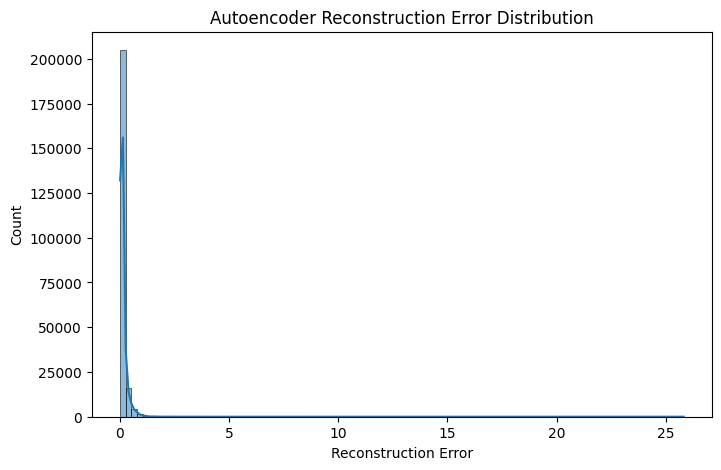

In [42]:

plt.figure(figsize=(8, 5))
sns.histplot(
    train["ae_recon_error"],
    bins=100,
    kde=True
)
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.show()

[saved] ..\experiments\figures\neural


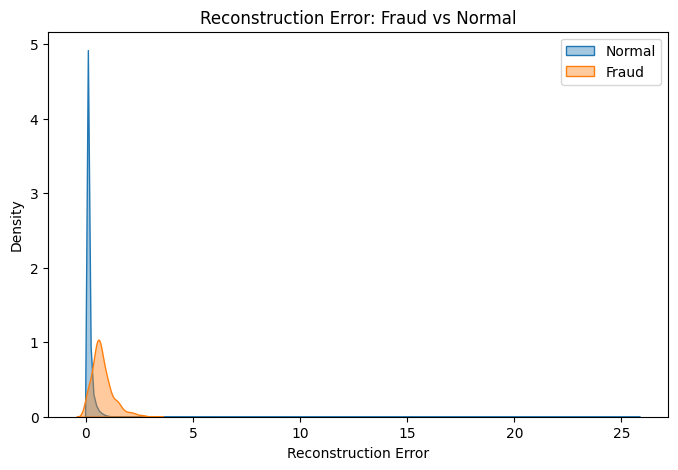

In [49]:
plt.figure(figsize=(8, 5))
sns.kdeplot(
    train.loc[train["Class"] == 0, "ae_recon_error"],
    label="Normal",
    fill=True,
    alpha=0.4
)
sns.kdeplot(
    train.loc[train["Class"] == 1, "ae_recon_error"],
    label="Fraud",
    fill=True,
    alpha=0.4
)

plt.title("Reconstruction Error: Fraud vs Normal")
plt.xlabel("Reconstruction Error")
plt.legend()
savefig("reconstruction.png")
plt.show()


### Save model weights

In [34]:

torch.save(autoencoder.state_dict(), "../experiments/models/autoencoder.pt")

print("Autoencoder weights saved to:", model_path)


Autoencoder weights saved to: ../experiments/models/mlp.joblib


## Merge neural features & save processed data

### Add neural features into train/test DataFrames

In [36]:

# Check MLP feature
assert "mlp_proba" in train.columns, "mlp_proba missing in train"
assert "mlp_proba" in test.columns, "mlp_proba missing in test"

# Check autoencoder latent features
ae_latent_cols = [col for col in train.columns if col.startswith("ae_latent_")]
assert len(ae_latent_cols) == 8, f"Expected 8 AE latent cols, found {len(ae_latent_cols)}"

# Check reconstruction error
assert "ae_recon_error" in train.columns, "ae_recon_error missing in train"
assert "ae_recon_error" in test.columns, "ae_recon_error missing in test"

print("Neural feature check passed.")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Neural feature check passed.
Train shape: (227845, 71)
Test shape: (56962, 71)


### Save updated train & test CSV

In [40]:

train_path = "../data/processed/train.csv"
test_path  = "../data/processed/test.csv"

train.to_csv(train_path, index=False)
test.to_csv(test_path, index=False)

print("Updated processed datasets saved.")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Updated processed datasets saved.
Train shape: (227845, 71)
Test shape: (56962, 71)


## summary

###  Neural Behavioral Intelligence (MLP + Autoencoder)

Traditional tree-based models like Random Forest and XGBoost are strong at learning rule-based splits and feature interactions, but they are limited to patterns explicitly exposed in the feature space. Neural networks, on the other hand, learn continuous, non-linear representations of behavior that are not easily captured by axis-aligned splits.

In this project, neural models are not used as final decision-makers. Instead, they are used as **feature generators** that extract behavioral signals from transaction data.

#### Why latent embeddings matter
Both the MLP and the autoencoder compress high-dimensional transaction features into low-dimensional latent representations. These embeddings capture complex interactions between amount, frequency, temporal behavior, and engineered features. While individual latent dimensions are not interpretable, together they encode how a transaction behaves relative to the overall population.

These embeddings become powerful inputs for stacking because they expose structure that supervised tree models would otherwise have to rediscover indirectly.

#### Why reconstruction error is a strong fraud signal
The autoencoder is trained in an unsupervised manner to reconstruct normal transaction behavior. Because fraud is rare and behaviorally irregular, it tends to reconstruct poorly, resulting in higher reconstruction error.

This reconstruction error acts as a continuous anomaly score:
- Low error → behavior consistent with the majority
- High error → behavior deviates from learned normal patterns

Unlike binary labels, this signal generalizes better to unseen or evolving fraud patterns.

#### Comparison with IsolationForest
IsolationForest detects anomalies by isolating points using random splits. While effective, it operates on shallow random partitions. The autoencoder instead learns a deep, non-linear model of normal behavior across all features simultaneously. As a result, reconstruction error captures subtler deviations that may not be extreme outliers in any single dimension.

Both signals are complementary rather than redundant.

#### Role in stacking
The neural features generated here (`mlp_proba`, autoencoder latent embeddings, and reconstruction error) are not final predictions. They serve as high-level behavioral inputs to the stacking meta-model in Day 7. The meta-model learns how to combine:
- supervised probabilities,
- unsupervised anomaly signals,
- and raw engineered features

to make more robust fraud decisions.

This separation of feature learning and decision-making mirrors how production fraud systems are designed.
